In [3]:
'''
Programmer: Mike Kovacevich
Last edited: 12/10/20
E-mail: mgk56@drexel.edu

Stacking sensitivity for different time windows and different gamma (spectral indices). Gamma will range from 2-3 and the time windows will range from 10^(-2) seconds to 10^5 seconds. Stacking sensitivity will be performed with Csky likelihood software.  
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import argparse
import histlite as hl
import csky as cy

#Building/loading MESC data from analysis directory

ana_dir = cy.utils.ensure_dir('/data/user/mkovacevich/FRB_analysis/cascades_ana')
repo = cy.selections.Repository()
ana = cy.get_analysis(repo, cy.selections.MESEDataSpecs.mesc_7yr, dir=ana_dir)

Setting up Analysis for:
MESC_2010_2016
Setting up MESC_2010_2016...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2013_MC.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC79_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2011_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2012_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2013_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2014_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2015_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2016_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC79_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/

In [4]:
#Directories to store the trials
#trials_dir = cy.utils.ensure_dir('/data/user/mkovacevich/FRB_analysis/trials')
#sig_dir = cy.utils.ensure_dir('{}/centered_dt_sig'.format(trials_dir))
#bg_dir = cy.utils.ensure_dir('{}/centered_dt_bg'.format(trials_dir))

#Calculating sensitivities, 3sigma at 90% and discovery potential as functions of different time windows for 1 FRB
#The time windows will range from ~1 ms to 10^4 seconds (following previous times windows)
cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 5.0

#Ordinarily, dt and gamma are passed as arguments so they are not usually declared as constants, uncomment code below for testing/check purposes
dt = 0.1
gamma = 3.0

#loading analysis object to get mjd of time data-set and events
a = ana.anas[0]

FRB_mjd_time = np.load('/data/user/mkovacevich/FRB_analysis/FRB_121102_mjd.npy', allow_pickle = True)

FRB_ra_rad = np.load('/data/user/mkovacevich/FRB_analysis/FRB_121102_RA.npy', allow_pickle = True)

FRB_dec_rad = np.load('/data/user/mkovacevich/FRB_analysis/FRB_121102_DEC.npy', allow_pickle = True)

FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.

print("Starting Trials")

##### Defining functions to compute flux ######    
def ndarray_to_TSD(trials):
    return cy.dists.TSD(cy.utils.Arrays(trials))

def tsd_merge(x):
    ts_values = np.concatenate([xx[0] for xx in x])
    n_zero = sum(xx[1] for xx in x)
    return cy.dists.TSD(ts_values, n_zero=n_zero)

def find_n_sig(beta=0.9, nsigma=None):
    # get signal trials, background distribution, and trial runner
    sig_trials = cy.bk.get_best(sig, 'n_sig')
    #b = cy.bk.get_best(bg) #, 'gamma', gamma, 'dt', dt)
    b = bg
    src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
    conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient",'flux': cy.hyp.PowerLawFlux(gamma)}
    tr = cy.get_trial_runner(conf, src = src, ana=ana)
    # determine ts threshold
    if nsigma is not None:
        ts = b.isf_nsigma(nsigma)
    else:
        ts = b.median()
    # include background trials in calculation
    trials = {0: tr.get_many_fits(10000)}
    trials.update(sig_trials)
    # get number of signal events
    # (arguments prevent additional trials from being run)
    result = tr.find_n_sig(ts, beta, max_batch_size=0, logging=False, trials=trials, n_bootstrap=1)
    # return flux
    return tr.to_E2dNdE(result, E0=1e5)

Starting Trials


In [10]:
time_windows = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
FRB_121102_gamma_3_sens = []
for i in time_windows:
    print(i)
    fluxs_sens = []
    dt = i
    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.
    gamma = 3.0
    bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/FRB_121102_trials/bg/dt/'+str(i)+'/',
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    sig = cy.bk.get_all('/data/user/mkovacevich/FRB_analysis/FRB_121102_trials/sig/gamma/3.0/dt/'+str(i)+'/','sig*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)
    fluxs_sens = find_n_sig(beta=0.9)
    FRB_121102_gamma_3_sens.append(fluxs_sens)
    print('sens = ' + str(fluxs_sens))
    

0.01
50 files loaded.                                                                            
1900 files loaded.                                                                                             
Performing 10000 background trials using 5.0 cores:
      10000/10000 trials complete.   
sens = 0.1022024573252207
0.1
50 files loaded.                                                                           
1900 files loaded.                                                                                            
Performing 10000 background trials using 5.0 cores:
      10000/10000 trials complete.   
sens = 0.10288978466352967
1.0
50 files loaded.                                                                           
1919 files loaded.                                                                                            
Performing 10000 background trials using 5.0 cores:
      10000/10000 trials complete.   
sens = 0.10147721374999986
10.0
50 files loaded.     

In [6]:
time_windows = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
FRB_121102_gamma_2_sens = []
for i in time_windows:
    print(i)
    fluxs_sens = []
    dt = i
    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.
    gamma = 2.0
    bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/FRB_121102_trials/bg/dt/'+str(i)+'/',
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    sig = cy.bk.get_all('/data/user/mkovacevich/FRB_analysis/FRB_121102_trials/sig/gamma/2.0/dt/'+str(i)+'/','sig*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)
    fluxs_sens = find_n_sig(beta=0.9)
    FRB_121102_gamma_2_sens.append(fluxs_sens)
    print('sens = ' + str(fluxs_sens))

0.01
50 files loaded.                                                                            
1900 files loaded.                                                                                             
Performing 10000 background trials using 5.0 cores:
      10000/10000 trials complete.   
sens = 0.6693072294260436
0.1
50 files loaded.                                                                           
1900 files loaded.                                                                                            
Performing 10000 background trials using 5.0 cores:
      10000/10000 trials complete.   
sens = 0.683422098207121
1.0
50 files loaded.                                                                           
1900 files loaded.                                                                                            
Performing 10000 background trials using 5.0 cores:
      10000/10000 trials complete.   
sens = 0.6847883297461459
10.0
50 files loaded.        

In [7]:
catalog_stacked_sens_gamma_2 = [0.42776688714680017, 0.42811340366870104, 0.4345044973793576, 0.4324263955864112, 0.43223290118101687, 0.4245982609723475, 0.3998979445747711,0.3985009152674313]
catalog_stacked_sens_gamma_3 = [0.10589442849608482, 0.1077493092441084, 0.10652667073322919, 0.10898243968659185, 0.10796400059738795, 0.1055303365847919, 0.11013134071451022, 0.14649931742425515]

Num_FRBs = 22
sens_gamma_3_perFRB = [x / Num_FRBs for x in catalog_stacked_sens_gamma_3]
sens_gamma_2_perFRB = [x / Num_FRBs for x in catalog_stacked_sens_gamma_2]

Num_FRB_121102 = 26
sens_gamma_3_perFRB121102 = [x / Num_FRB_121102 for x in FRB_121102_gamma_3_sens]
sens_gamma_2_perFRB121102 = [x / Num_FRB_121102 for x in FRB_121102_gamma_2_sens]

gamma_2_sens_ratio = np.divide(sens_gamma_2_perFRB, sens_gamma_2_perFRB121102)
gamma_3_sens_ratio = np.divide(sens_gamma_3_perFRB, sens_gamma_3_perFRB121102)

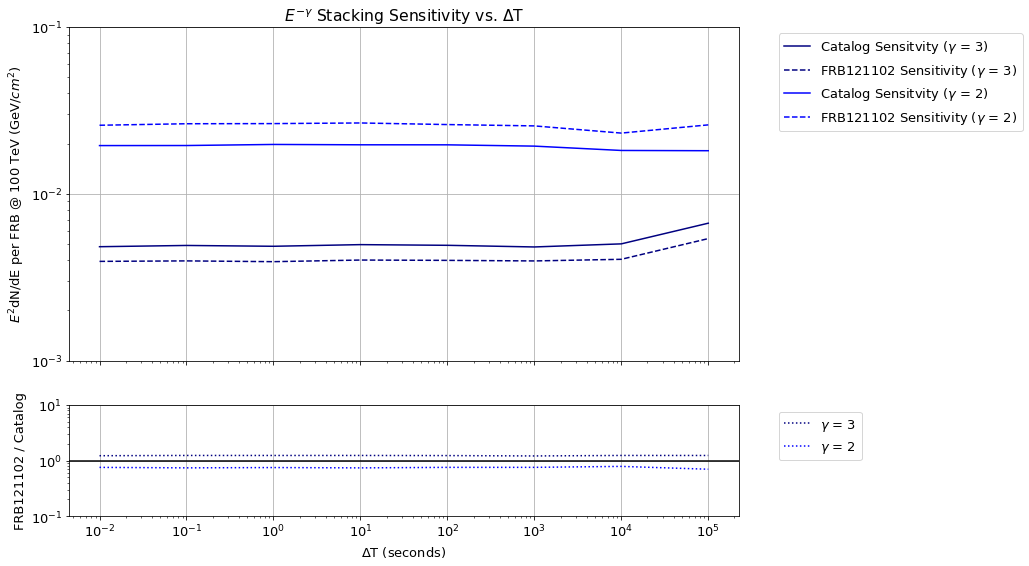

In [14]:
plt.rcParams.update({'font.size': 13})
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9), gridspec_kw = {'height_ratios':[3, 1]}, sharex=True)
#ax1.subplot(2, 1, 1)
ax1.plot(time_windows, sens_gamma_3_perFRB, color = 'navy', label = 'Catalog Sensitvity ($\gamma$ = 3)')
ax1.plot(time_windows, sens_gamma_3_perFRB121102,  color = 'navy', linestyle='--', label = r'FRB121102 Sensitivity ($\gamma$ = 3)')
ax1.plot(time_windows, sens_gamma_2_perFRB,  color = 'blue', label = r'Catalog Sensitvity ($\gamma$ = 2)')
ax1.plot(time_windows, sens_gamma_2_perFRB121102,  color = 'blue', linestyle='--', label = r'FRB121102 Sensitivity ($\gamma$ = 2)')


ax1.set_ylim(.001, 0.1)
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_ylabel(r'$E^{2}$dN/dE per FRB @ 100 TeV (GeV/$cm^{2}$)')
ax1.grid(True)
ax1.set_title(r'$E^{-\gamma}$ Stacking Sensitivity vs. $\Delta$T')
ax1.patch.set_facecolor('white')
ax1.legend(bbox_to_anchor=(1.05, 1))
#plt.subplots_adjust(hspace = 3.0)

#ax2.subplot(2, 1, 2)
#ax2.subplots(figsize=(10,5))
ax2.set_ylim(.1, 10.)
ax2.plot(time_windows, gamma_3_sens_ratio, color = 'navy', linestyle=':',label = '$\gamma$ = 3')
ax2.plot(time_windows, gamma_2_sens_ratio, color = 'blue', linestyle=':',label = '$\gamma$ = 2')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.axhline(y=1., color = 'black')
ax2.grid()
ax2.set_ylabel('FRB121102 / Catalog')
ax2.set_xlabel(r'$\Delta$T (seconds)' )
ax2.legend(bbox_to_anchor=(1.05, 1), loc = 2)
fig.patch.set_facecolor('white')

fig.savefig('/home/mkovacevich/public_html/plots/Catalog_Burst_StackingSensitivityComparisons.png', bbox_inches='tight')
#plt.subplots_adjust(hspace = 3.0)